### Linear Regression

We show the interpretation of a linear regression model with a dataset of brain weights and body weights for mammalian species. 

In [26]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# Read data in as a pandas df
df = pd.read_csv("data_01_brains.txt", delimiter='\t')

We decide to transform the data to log-scale as the original data does not seem to meet the assumptiosn of a linear model. This will also change the way we interpret regression coefficients. 

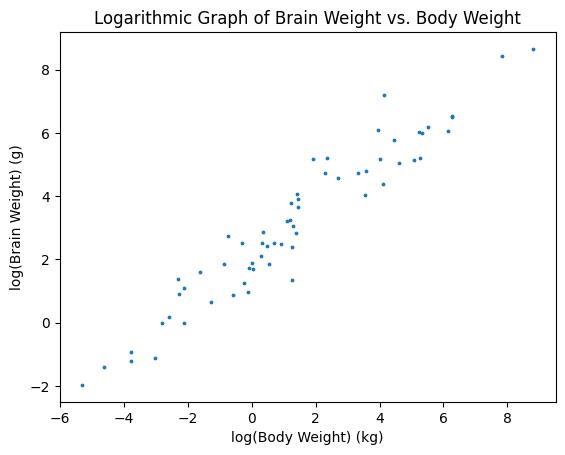

In [28]:
# Transform data to log-scale
df = df.assign(log_Body_Weight = lambda x: np.log(df['Body.Weight']),
          log_Brain_Weight = lambda x: np.log(df['Brain.Weight']))

# Visualize transformed data
x = df['log_Body_Weight'].to_numpy()
y = df['log_Brain_Weight'].to_numpy()

plt.scatter(x, y, s=3)
plt.xlabel("log(Body Weight) (kg)")
plt.ylabel("log(Brain Weight) (g)")
plt.title("Logarithmic Graph of Brain Weight vs. Body Weight")
plt.show()

In [30]:
# Calculate Regression Coefficients (math approach)
mean_x = np.mean(x)
mean_y = np.mean(y)
numerator = np.sum((x - mean_x) * (y - mean_y))
denominator = np.sum((x - mean_x) ** 2)
m = numerator/denominator
b = mean_y - m * mean_x
print("Coefficient: ", m)
print("Intercept: ", b)


Coefficient:  0.7516859362419007
Intercept:  2.134788676764636


In [31]:
from sklearn.linear_model import LinearRegression

# Calculate Regression Coefficients (using built-in libraries)
model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
print(f'Coefficient: {model.coef_}')
print(f'Intercept: {model.intercept_}')


Coefficient: [[0.75168594]]
Intercept: [2.13478868]


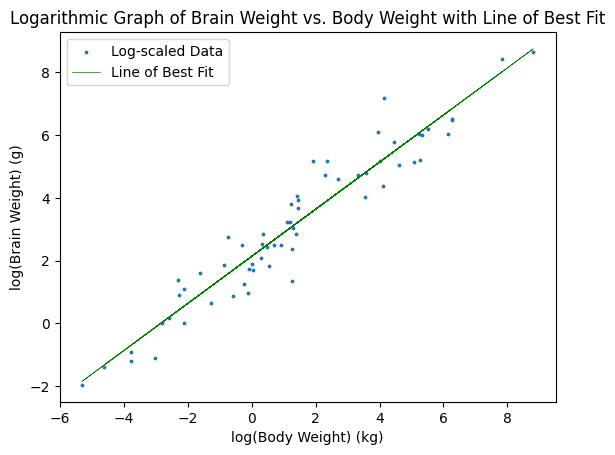

In [32]:
# Plot regression line
y_pred = m*x + b

plt.scatter(x, y, s=3, label="Log-scaled Data")
plt.plot(x, y_pred, color = 'green', linewidth=0.5, label = "Line of Best Fit")
plt.legend()
plt.xlabel("log(Body Weight) (kg)")
plt.ylabel("log(Brain Weight) (g)")
plt.title("Logarithmic Graph of Brain Weight vs. Body Weight with Line of Best Fit")
plt.show()

Interpretation: For every unit increase in X, the predicted value of y increased by 75%. 

In [17]:
import statsmodels.api as sm

X_const = sm.add_constant(x)
model_sm = sm.OLS(y, X_const).fit()

# Display the summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     697.4
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           9.84e-35
Time:                        00:25:03   Log-Likelihood:                -64.336
No. Observations:                  62   AIC:                             132.7
Df Residuals:                      60   BIC:                             136.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1348      0.096     22.227      0.0

### LASSO

When working with many features, we can apply a regularization technique to add a penalty and prevent overfitting. We use a chemical SMILES dataset with the hemotoxicity of molecules. This section is to show how we can deal with models with many coefficients and remove the insignificant ones. 

Run 'pip install rdkit-pypi' before this section

In [35]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

url = "https://raw.githubusercontent.com/RekerLab/DeepDelta/main/Datasets/Benchmarks/HemoTox.csv"
c = pd.read_csv(url)

# Convert SMILES to molecules
mols = [Chem.MolFromSmiles(s) for s in c['SMILES']]

# Create binary fingerprints for robust ML models
fps = np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(m,2)) for m in mols])

# Create descriptors for ML models with higher interpretability
from rdkit.Chem import Descriptors
descr = Descriptors._descList
calc = [x[1] for x in descr]
d_name = [x[0] for x in descr]

desc = np.array([np.array([f(m) for f in calc]) for m in mols])

# Convert the numpy array to a pandas DataFrame with descriptor names as columns
X = pd.DataFrame(desc, columns=d_name)
y = c['Y']

In [37]:
# Filter out missing observations and 0-variance features
from sklearn.feature_selection import VarianceThreshold
print("Original shape of feature data:", X.shape)
missing = X.isna().sum().sum()
print("Total missing values:", missing)
X_new = X.dropna()
print("Shape of feature data after removing missing observations:", X_new.shape)
selector = VarianceThreshold()
X_new = selector.fit_transform(X_new)
print("Total 0-variance features:", X.shape[1] - X_new.shape[1])
print("Shape of feature data after removing 0-variance features:", X_new.shape)
X_new = pd.DataFrame(X_new, columns=X.columns[selector.get_support()])

Original shape of feature data: (828, 208)
Total missing values: 0
Shape of feature data after removing missing observations: (828, 208)
Total 0-variance features: 28
Shape of feature data after removing 0-variance features: (828, 180)


In [38]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

# Initialize the Lasso model with L1 regularization
clf = Lasso(alpha=0.1, random_state=42)
clf.fit(X_train, y_train)

# Get the coefficients and their corresponding feature names
coeff = clf.coef_
coeff_df = pd.DataFrame({'Feature': X_new.columns, 'Coefficient': coeff})
coeff_df['Absolute Value'] = coeff_df['Coefficient'].abs()
sorted_coeff = coeff_df.sort_values(by='Absolute Value', ascending=False)
sorted_coeff.head(10)

,Feature,Coefficient,Absolute Value
18,BCUT2D_CHGHI,-0.144847,0.144847
115,NumSaturatedHeterocycles,-0.133519,0.133519
160,fr_lactone,-0.131667,0.131667
13,FpDensityMorgan1,0.112480,0.112480
24,BalabanJ,0.064812,0.064812
63,SMR_VSA5,-0.019528,0.019528
99,VSA_EState9,0.013137,0.013137
98,VSA_EState8,-0.009438,0.009438
130,fr_C_O,-0.000000,0.000000
121,fr_Al_OH,-0.000000,0.000000


In [39]:
# Predict on the test set using the fitted model
y_pred = clf.predict(X_test)

# Calculate the R^2 value and print
r2 = r2_score(y_test, y_pred)
print(f"R^2 value of the LASSO model on test data: {r2:.4f}")

R^2 value of the LASSO model on test data: 0.4543


Since the R^2 value is low, our model is most likely removing important coefficients, so we should adjust the penalty term. 